# TP Large Scale Kernel Methods

In [29]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file

## Chargement et partitionnement des données

In [30]:
###############################################################################
# Requires file ijcnn1.dat.gz to be present in the directory

dataset_path = 'ijcnn1.dat'
ijcnn1 = load_svmlight_file(dataset_path)
X = ijcnn1[0].todense()
y = ijcnn1[1]

###############################################################################
# Extract features

X_train, X_test, y_train, y_test = train_test_split(X[:60000, :], y[:60000],
                     train_size=20000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n1, p = X_train.shape
n2 = X_test.shape[0]

print("Nombre d'exemples d'apprentissage:", n1)
print("Nombre d'exemples de test:", n2)
print("Nombre de features:", p)

Nombre d'exemples d'apprentissage: 20000
Nombre d'exemples de test: 40000
Nombre de features: 22


## Question 1

On va fitter nos données d'apprentissage avec un SVM linéaire et un SVM non-linéaire (noyau Gaussien) pour comparer leur score de prédiction ainsi que le temps de calcul nécessaire à l'apprentissage et à la prédiction.

In [41]:
from sklearn.svm import SVC, LinearSVC
from time import time

print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
t0 = time()
# SVC fitting
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t1 = time()
# SVC predicting
y_pred = clf.predict(X_test)

# SVC predicting time and accuracy
print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t1
accuracy_kernel = clf.score(X_test, y_test)
print("classification accuracy: %0.3f" % accuracy_kernel)

# TODO same for LinearSVC

print("Fitting LinearSVC rbf on %d samples..." % X_train.shape[0])
t0_linear = time()
# SVC fitting
clf_linear = LinearSVC(dual = False) # dual = False when n_samples >> n_features
clf_linear.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0_linear))

print("Predicting with LinearSVC on %d samples..." % X_test.shape[0])
t1_linear = time()
# Linear SVC predicting
y_pred_linear = clf_linear.predict(X_test)

# Linear SVC predicting time and accuracy
print("done in %0.3fs" % (time() - t1_linear))
timing_linear = time() - t1_linear
accuracy_linear = clf_linear.score(X_test, y_test)
print("classification accuracy: %0.3f" % accuracy_linear)

Fitting SVC rbf on 20000 samples...
done in 2.266s
Predicting with SVC rbf on 40000 samples...
done in 2.547s
classification accuracy: 0.980
Fitting LinearSVC rbf on 20000 samples...
done in 0.038s
Predicting with LinearSVC on 40000 samples...
done in 0.001s
classification accuracy: 0.917


Comments : The linearSVC uses the simplest kernel function "linear kernel". In fact, it does not involve the calculation of non-linear kernel which is the time-consumming part of the fitting process. With the same reason, LinearSVC can't apply a non-linear seperation within the original feature space, so the accuracy of classification is much worse than the SVC with gaussien kernel.  

## Question 2

On code une fonction qui calcule la meilleure approximation de rang $k$.

In [32]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd
from numpy.linalg import multi_dot

def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G.

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    if fast:
        u, s, vt = svds(gram_mat, k=k)
        gram_mat_k = multi_dot([u, np.diag(s), vt])
    else:
        u, s, vt = svd(gram_mat)
        gram_mat_k = multi_dot([u[:,:k], np.diag(s[:k]), vt[:k,:]])

    return gram_mat_k


## Question 3

On applique cette fonction sur la matrice décrite dans le sujet de TP.

In [33]:
p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

# gram_signal (p*p)
gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
# svd dim k = ranks 100
n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error = np.zeros(n_ranks)

for k, rank in enumerate(ranks):
    print(k, rank)
    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=True)
    timing_fast[k] = time() - t0

    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=False)
    timing_slow[k] = time() - t0

    # TODO: compute relative error with Frobenius norm
    rel_error[k] = linalg.norm(gram_mat_k - gram_signal, ord='fro')/linalg.norm(gram_signal, 'fro')

0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100


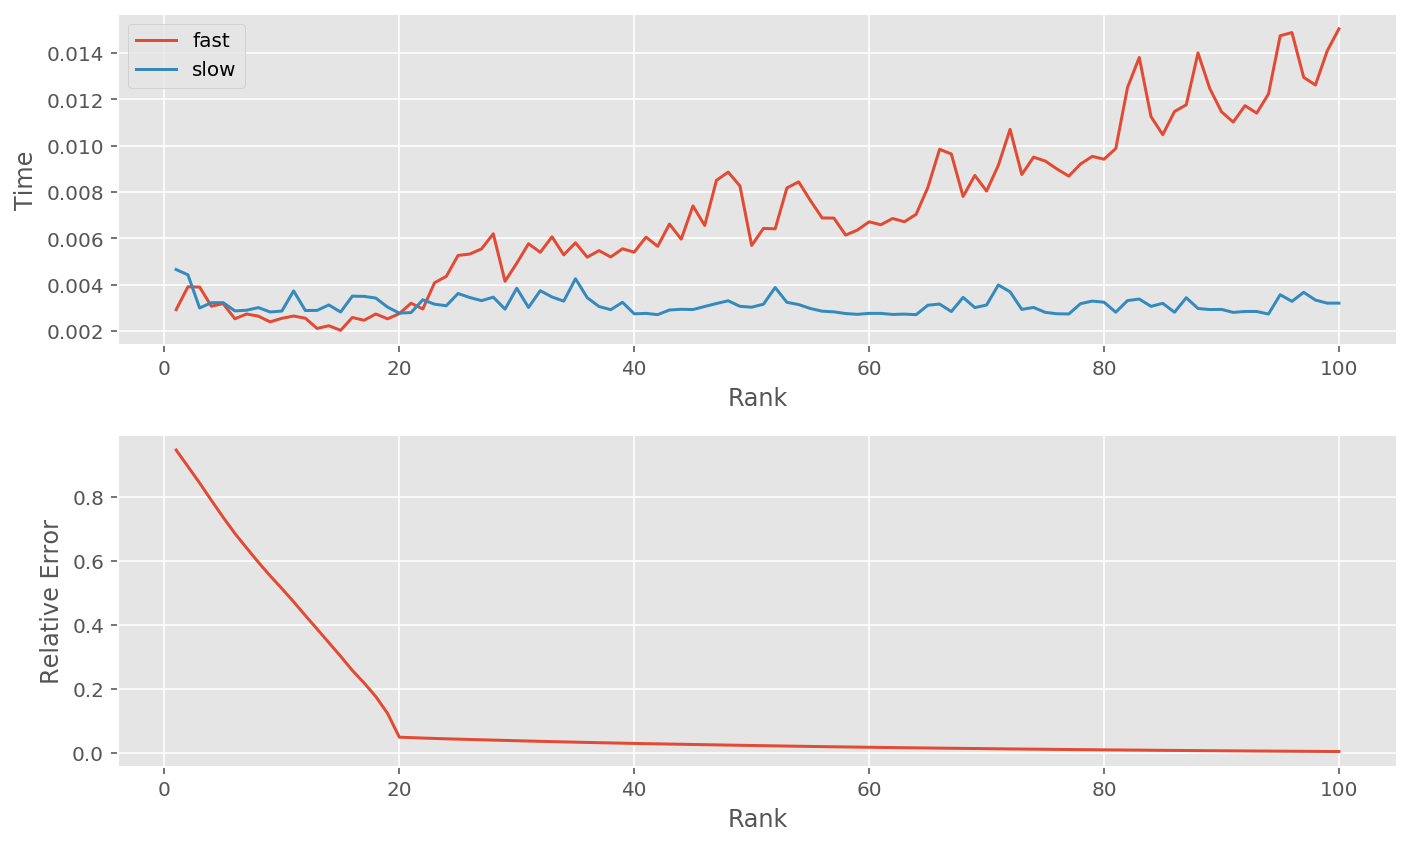

In [34]:
###############################################################################
# Display
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-', label='fast')
ax1.plot(ranks, timing_slow, '-', label='slow')
ax1.legend()

ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')
ax2.plot(ranks, rel_error, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')
plt.tight_layout()
plt.show()

Comment: 

1. The svd is in principal a process where we try to find an approximated matrix (distance measured by the frobenius norm) with lower rank (k) to the given matrix. The second graph shows that the calculated matrix with rank = 20 can keep most information (variance) of the original matrix.   
2. As the first graph shows, we can observe that at lower k(<20), the fast method (using svds) is really faster than the slow method(using svd). With k increasing, the svds method becomes more and more slower. This could be due to the data's sparsity because the svds methode aims to solve the sparse input matrix (the input matrix is very dense). 


## Question 4

On va implémenter l'algorithme de Random Kernel Features pour le noyau Gaussien.

In [35]:
def random_features(X_train, X_test, gamma, c=300, seed=44):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples, n_features = X_train.shape
    
    # Generate W which follows the normal distribution (0, 2gamma)
    W = rng.normal(0, np.sqrt(2*gamma), (n_features, c))
    # Generate b which follows an uniforme distribution between [0, 2pi]
    b = rng.uniform(0, 2*np.pi, (1,c))
    
    X_new_train = np.sqrt(2/c)*np.cos(np.dot(X_train,W)+b)
    X_new_test = np.sqrt(2/c)*np.cos(np.dot(X_test,W)+b)
    
    return X_new_train, X_new_test

## Question 5

On va maintenant appliquer cette méthode avec $c=300$.

In [36]:
n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features

Z_train, Z_test = random_features(X_train, X_test, gamma, c=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)

Fitting SVC linear on 20000 samples...
done in 1.186s
Predicting with SVC linear on 40000 samples...
done in 0.015s
classification accuracy: 0.963


Comments: Compared with the results of SVC(rbf), the random kernel features method has really reduced the fitting time (2.37s to 1.28s) and also the prediction time (2.43s to 0.018s). But the accuraccy has dropped a little bit from 0.98 to 0.96. In this case, the number of components we used is 300, so we have the c << n^2 (makes the fitting time reduced), and c << n (makes the prediction time reduced).

## Question 6

On implémente la méthode de Nystrom.

In [37]:
from sklearn.metrics.pairwise import rbf_kernel

def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)

    X_train_idx = X_train[idx, :]
    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)
    
    # TODO
    u, s, vt = linalg.svd(W, full_matrices=False)
    
    u = u[:,:k]
    s = s[:k]
    vt = vt[:k, :]
    
    W_k = np.dot(u, np.dot(np.diag(s), vt))
    
    M = np.dot(u, np.diag(1/np.sqrt(s)))
    
    C_train = rbf_kernel(X_train, X_train_idx, gamma=gamma)
    C_test = rbf_kernel(X_test, X_train_idx, gamma=gamma)
    
    X_new_train = np.dot(C_train, M)
    X_new_test = np.dot(C_test, M)

    return X_new_train, X_new_test

## Question 7

On va maintenant appliquer cette méthode également avec $c=500$ et $k=300$

In [38]:
gamma = 1/n_features
Z_train, Z_test = nystrom(X_train, X_test, gamma = gamma , c=500, k=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)


Fitting SVC linear on 20000 samples...
done in 0.974s
Predicting with SVC linear on 40000 samples...
done in 0.019s
classification accuracy: 0.976


## Question 8

On va maintenant réaliser une synthèse des performances des RKF et de Nystrom pour un ensemble de paramètres.

In [44]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)
timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    print(i, c)
    # TODO: compute time and prediction scores for RKF and Nystrom with respect to c
    # put results in timing_rkf, timing_nystrom, accuracy_rkf, accuracy_nystrom
    
    ## Nystorm
    Z_ny_train, Z_ny_test = nystrom(X_train, X_test, gamma, c=c, k=c-10, seed=44)

    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_ny_train, y_train)
    accuracy_nystrom[i] = clf.score(Z_ny_test, y_test)
    timing_nystrom[i] = time() - t0

    ## RKF
    Z_rkf_train, Z_rkf_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_rkf_train, y_train)
    accuracy_rkf[i] = clf.score(Z_rkf_test, y_test)
    timing_rkf[i] = time() - t0

Training SVMs for various values of c...
0 20
1 70
2 120
3 170
4 220
5 270
6 320
7 370
8 420
9 470
10 520
11 570


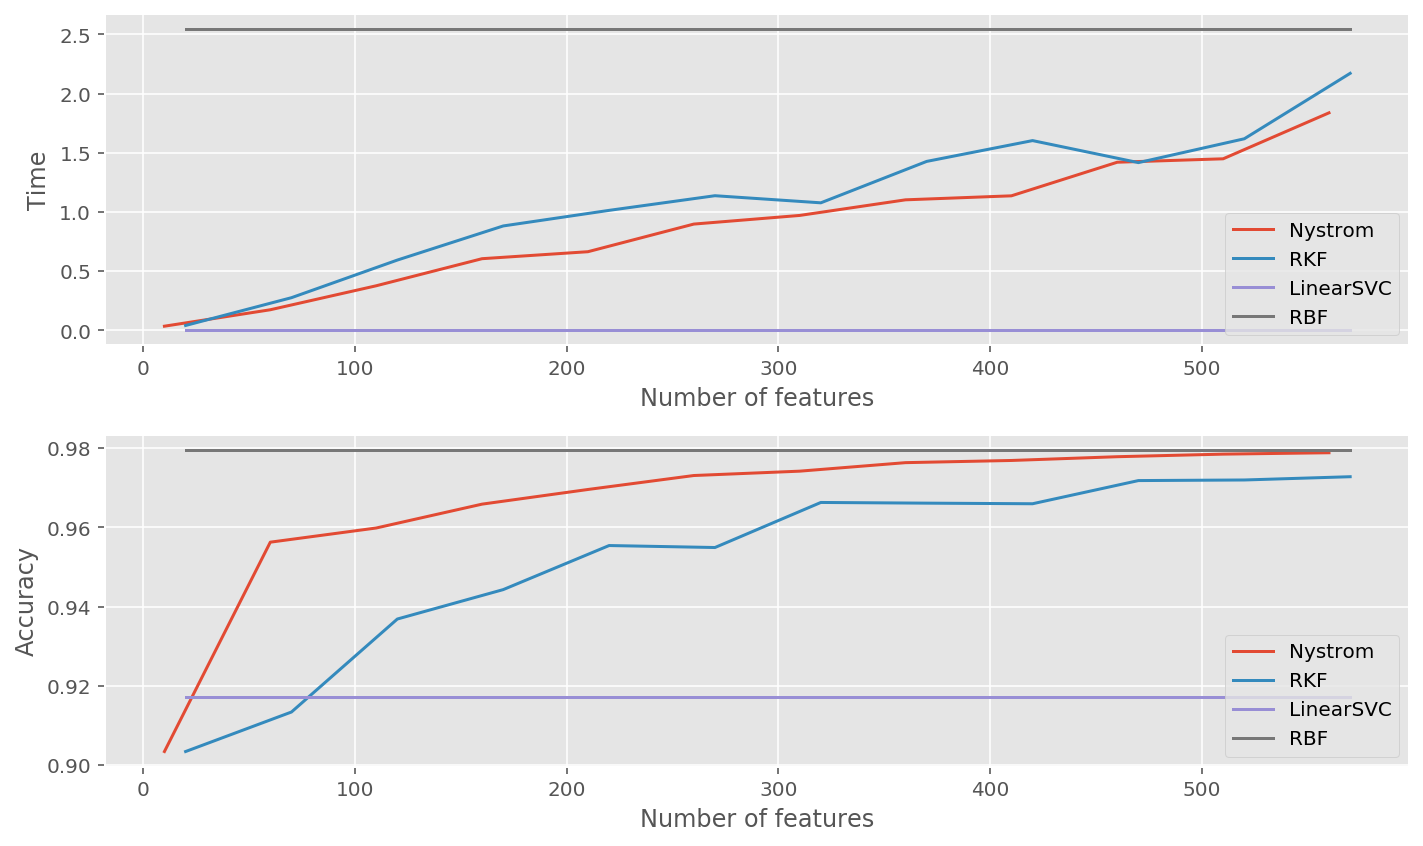

In [45]:
###############################################################################
# Display bis

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

# setting k < c (k=c-10) to remove the noise contained in smallest eigenvalues of W
ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()

Comments: The caluculation time of these two methods are very close (theoretically, both methods converge in a same rate of O(1/sqrt(c))) while the prediction accruracy of Nystrom is better than the RKF method in our case (generally, Nystrom tends to achieve better performance at equal number of random samples).  